In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## PRN : ___________________________________
## Name: ___________________________________

# Introduction to AI and OpenVino
## Assignment 05 - Santander XGBOOST

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [23]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


In [24]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join( 'input')

# set location of inputs for this module
moduleDir = 'santendar'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [25]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [26]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [27]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Question:
* What did you do too address missing values?
* What data wrangling do you recommend?

In [28]:
inpDir = os.path.join('Input')
train_df = pd.read_csv( 'train.csv')
inpDir = os.path.join('Input')
test_df = pd.read_csv( 'test.csv')

display(train_df.head())
display(test_df.head())


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [29]:
train_df['TARGET'].value_counts()

TARGET
0    73012
1     3008
Name: count, dtype: int64

In [30]:
class_names = train_df['TARGET'].unique()
class_names

array([0, 1])

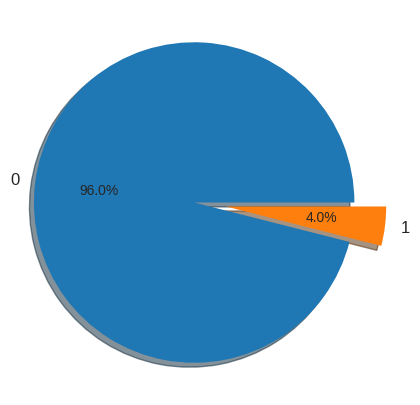

In [31]:
fig, ax= plt.subplots(figsize = (5,5))
explode = (0, 0.2)
ax.pie(train_df['TARGET'].value_counts(), explode=explode,
       labels=class_names,autopct='%1.1f%%', shadow=True, startangle = 0)
ax.axis('equal')
plt.show()

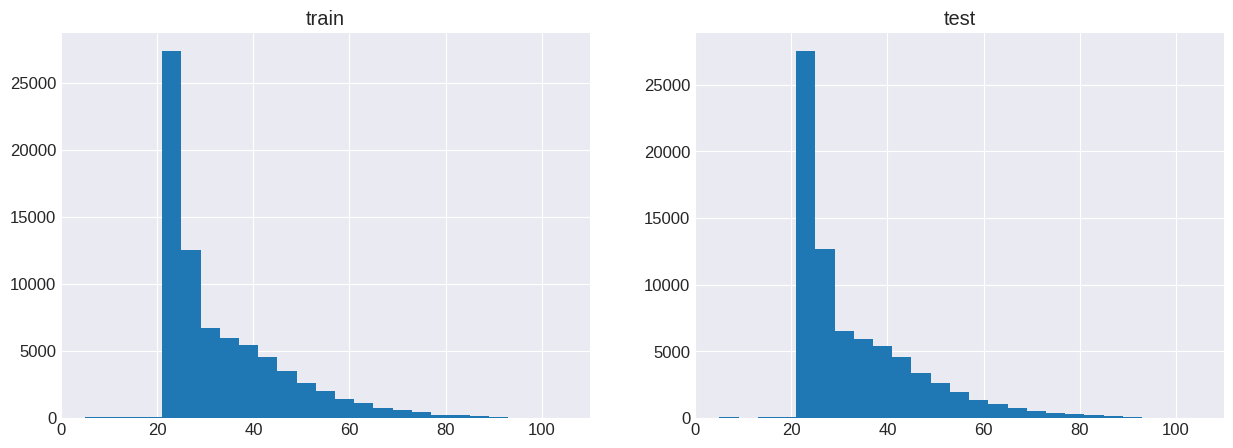

In [ ]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
train_df['var15'].hist(bins=25, ax = ax)
ax.set_title('train');
ax =axes[1]
test_df['var15'].hist(bins=25, ax =ax)
ax.set_title('test');

In [ ]:
print(len(train_df['TARGET'][train_df.var15<23]))
print(sum(train_df['TARGET'][train_df.var15<23]))

1212
0


In [ ]:
train_df['n0'] = (train_df==0).sum(axis=1)
test_df['n0'] = (test_df==0).sum(axis=1)

print(test_df.shape)
print (train_df.shape)

(75818, 371)
(76020, 372)


In [ ]:
drop_cols= []
for col in train_df.columns:
    if train_df[col].std()==0:
        drop_cols.append(col)

train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

(76020, 338) (75818, 337)


In [ ]:
drop_cols= []
cols = train_df.columns

for i in range(len(cols)-1):
    v = train_df[cols[i]].values
    for j in range(i+1, len(cols)):
        if np.array_equal(v,train_df[cols[j]].values):
            drop_cols.append(cols[j])


print(len(drop_cols))
print(drop_cols)

29
['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']


In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [ ]:
RANDOM_STATE=24
N_SAMPLES=1000
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_clusters_per_class=1, n_samples=N_SAMPLES, random_state=RANDOM_STATE)
print('original dataset shsape %s' % Counter(y))
sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X,y)
print('resampled dataset shape %s' % Counter(y_res))

original dataset shsape Counter({1: 900, 0: 100})
resampled dataset shape Counter({1: 900, 0: 900})


In [ ]:
import matplotlib.patheffects as PathEffects
def digit_scatter(x, labels):
    '''
    Arg:
        x: (dimentional data)
        labels :
    
    '''
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    fig, ax = plt.subplots(figsize= (6,6))
    
    ax.set_aspect('auto')
    
    sc = ax.scatter(x[:,0], x[:,1], s=15, c= palette[labels.astype(np.int16)], edgecolors= 'k')
    ax.axis('off')
    ax.axis('tight')
    txts = []
    
    for i in range(num_classes):
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        
        txt.set_path_effects([
            PathEffects.stroke(linewidth = 5,  foreground ='w'),
            PathEffects.normal()
        ])

In [33]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('Input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

In [34]:
iris_file = os.path.join('iris.csv')

iris_feature = [
    'sepal lenght' ,  'sepal width' , 'petal lenght' , 'petal width' , 'target'
]
iris_df = pd.read_csv(iris_file , sep=',' , skiprows=1 , header=None , names=iris_feature)
features = iris_df.drop('target',axis=1).to_numpy()
labels = iris_df['target']
num_classes = np.unique(labels)



NameError: name 'txt' is not defined

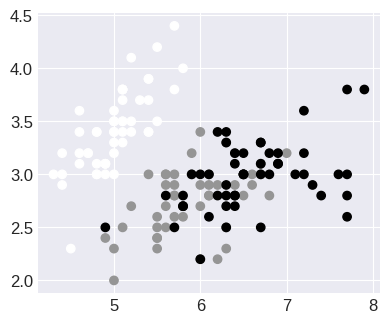

In [39]:
kk = 1
plt.figure(figsize=(15, 8))
for ii in range(features.shape[1]-1):
    for jj in range(ii+1, (features.shape[1])):
        ax = plt.subplot(2, 3, kk)
        kk += 1 
        ax.scatter(features[:,ii], features[:,jj], c = labels)
        for i in num_classes:
            Xtext = np.median(features[labels == i, ii], axis= 0)
            ytext = np.median(features[labels == i, jj], axis=0)
            txt.set_path_effects([ PathEffects.stroke(linewidth = 5,  foreground ='w'),
            PathEffects.normal()])
        ax.set_title('{} vs {}'. format(iris_feature[ii],iris_feature[jj]))
        ax.ti

In [37]:
pca = PCA(n_components=2)

pca.fit(X_scaled)

NameError: name 'X_scaled' is not defined

In [38]:
pca.components_

AttributeError: 'PCA' object has no attribute 'components_'

In [ ]:
pca.explained_variance_ratio_

NameError: name 'pca' is not defined

In [ ]:
pca.explained_variance_ratio_.sum()

NameError: name 'pca' is not defined

In [ ]:
x_pca = pca.transform(X_scaled)

NameError: name 'pca' is not defined

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbous=50

In [ ]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

NameError: name 'StandardScaler' is not defined

In [ ]:
pca = PCA(n_componets=2)
projections = pca.fit_transform(X_scaled, y)
print (projections.shape)

NameError: name 'PCA' is not defined

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis( n_componets=2)
data = X_scaled.copy()
projections = lda.fit_transform(data, y)
print(projections.shape)

TypeError: LinearDiscriminantAnalysis.__init__() got an unexpected keyword argument 'n_componets'